In [64]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 13

from astropy.cosmology import LambdaCDM
from astroML.datasets import generate_mu_z
from astroML.linear_model import PolynomialRegression, BasisFunctionRegression, NadarayaWatson
from sklearn.model_selection import KFold


##  Data & true cosmology curve

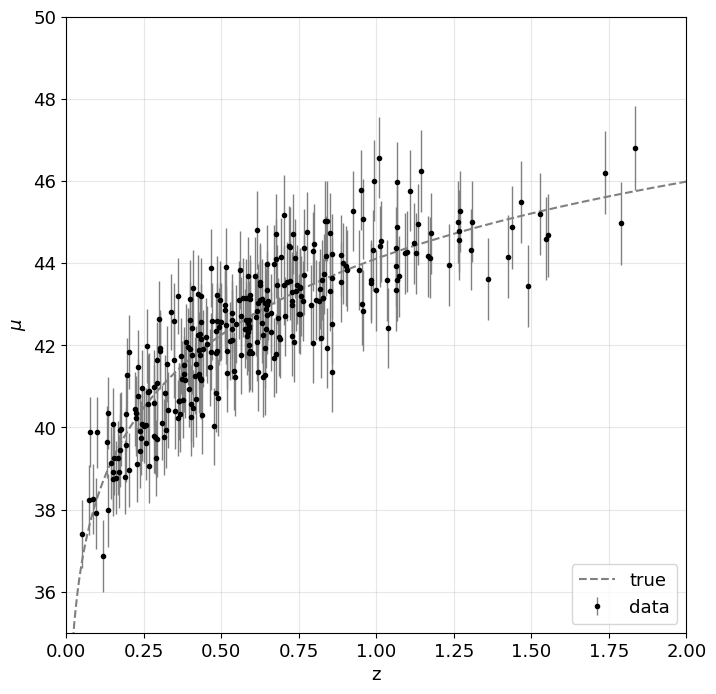

In [65]:

# Generate data
z_sample, mu_sample, dmu = generate_mu_z(300, random_state=1234)

# True curve 
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=1-0.27)
z = np.linspace(0.01, 2, 1000)
mu_true = cosmo.distmod(z)

# Plot data and true curve
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(z, mu_true, '--', c='gray', label='true')
plt.xlabel("z"); plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2); plt.ylim(35,50); plt.grid(True, alpha=0.3)
plt.show()


## Linear regression: Polynomial , Basis Functions , Kernel

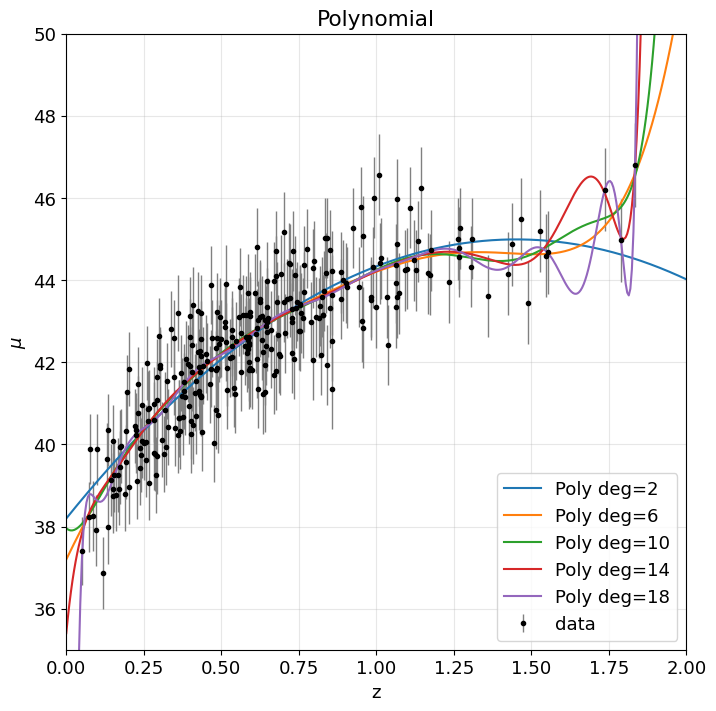

In [66]:

# Polynomial regression 
degrees_to_show = list(np.arange(1, 20)[1::4])  # 2,6,10,14,18
zgrid = np.linspace(0.0, 2.0, 400)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
for n in degrees_to_show:
    reg = PolynomialRegression(degree=n)
    reg.fit(z_sample[:, None], mu_sample, dmu)  # weighted fit
    mu_fit = reg.predict(zgrid[:, None])
    plt.plot(zgrid, mu_fit, label=f'Poly deg={n}')
plt.xlabel("z"); plt.ylabel("$\mu$")
plt.title("Polynomial")
plt.legend(loc='lower right'); plt.xlim(0,2); plt.ylim(35,50); plt.grid(True, alpha=0.3)
plt.show()


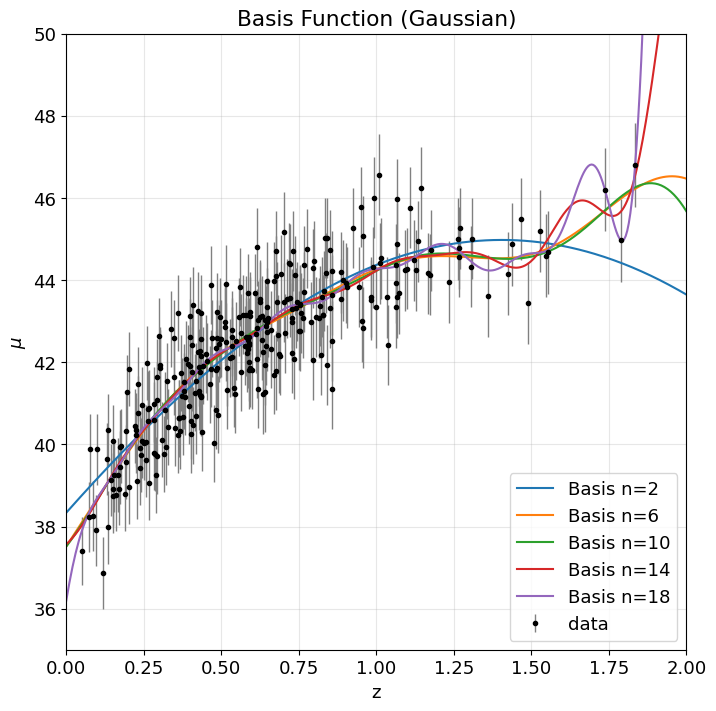

In [67]:

# Basis Function Regression (Gaussian)
ns_to_show = list(np.arange(1, 20)[1::4])  # 2,6,10,14,18

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
for n in ns_to_show:
    basis_mu = np.linspace(0, 2, n)[:, None]                  
    basis_sigma = 1.0 * (basis_mu[1] - basis_mu[0]) if n>1 else 0.1  
    reg = BasisFunctionRegression('gaussian', mu=basis_mu, sigma=basis_sigma)
    reg.fit(z_sample[:, None], mu_sample, dmu)  # weighted fit
    mu_fit = reg.predict(zgrid[:, None])
    plt.plot(zgrid, mu_fit, label=f'Basis n={n}')
plt.xlabel("z"); plt.ylabel("$\mu$")
plt.title("Basis Function (Gaussian)")
plt.legend(loc='lower right'); plt.xlim(0,2); plt.ylim(35,50); plt.grid(True, alpha=0.3)
plt.show()


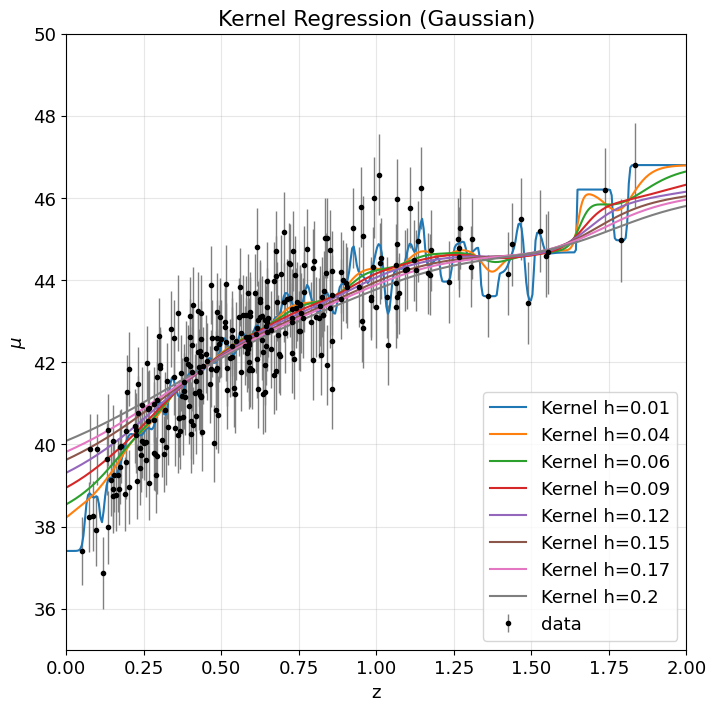

In [68]:

# Kernel Regression (Gaussian kernel)
bws_to_show = np.round(np.linspace(0.01, 0.2, 8), 2)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
for bw in bws_to_show:
    reg = NadarayaWatson('gaussian', bw)
    reg.fit(z_sample[:, None], mu_sample)  
    mu_fit = reg.predict(zgrid[:, None])
    plt.plot(zgrid, mu_fit, label=f'Kernel h={bw}')
plt.xlabel("z"); plt.ylabel("$\mu$")
plt.title("Kernel Regression (Gaussian)")
plt.legend(loc='lower right'); plt.xlim(0,2); plt.ylim(35,50); plt.grid(True, alpha=0.3)
plt.show()


## K-fold CV: train vs validation error curves

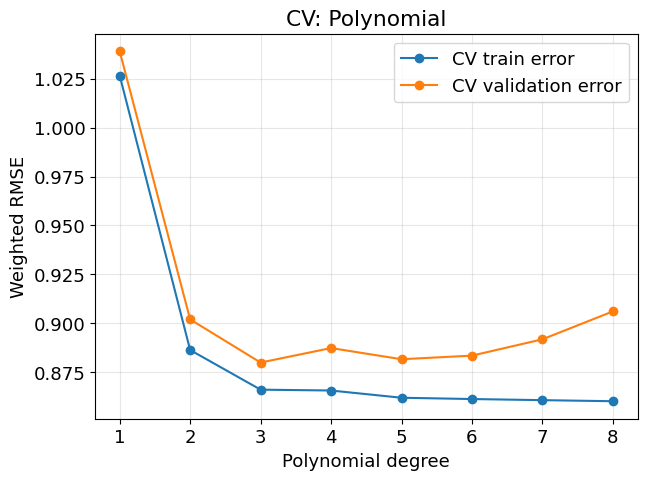

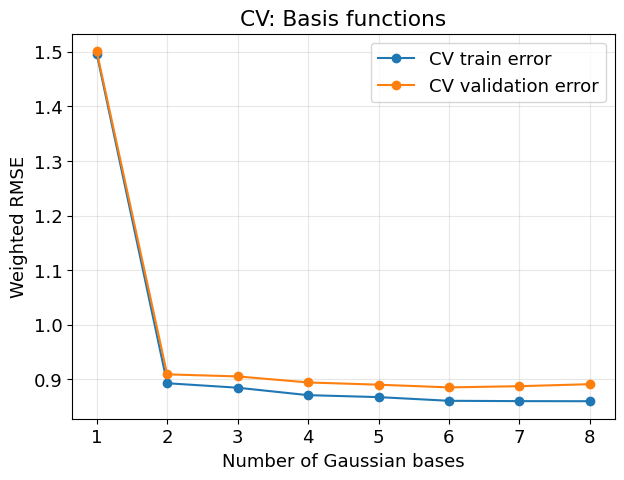

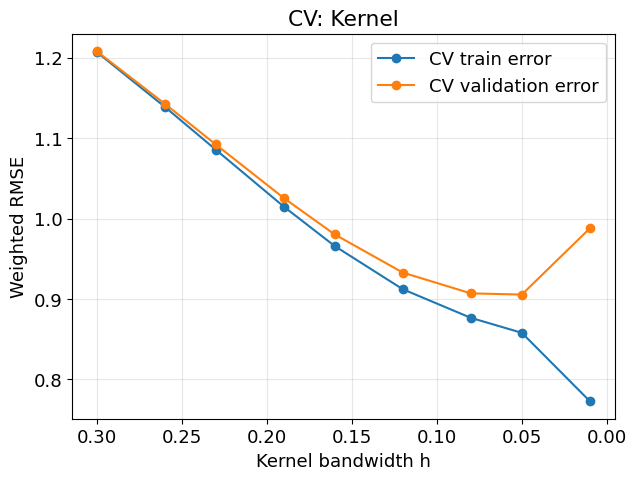

Best by CV (hyperparam, CV-val error):
  Polynomial: (3, 0.8797900338753454)
  Basis     : (6, 0.885529634005884)
  Kernel    : (0.05, 0.9054834075003291)


In [69]:
#Compute weighted RMSE
def weighted_mse(y_true, y_pred, sigma):
    w = 1.0/(np.asarray(sigma)**2)
    return np.sqrt(np.sum(w*(y_true - y_pred)**2) / np.sum(w))

#K-fold CV for polynomial regression
def cv_train_val_curves_poly(degrees, X, y, s, k=8):
    kf = KFold(n_splits=k, shuffle=True, random_state=11)
    degs, mean_tr, mean_va, std_tr, std_va = [], [], [], [], []
    for n in degrees:
        tr_errs, va_errs = [], []
        for tr, te in kf.split(X):
            reg = PolynomialRegression(degree=n)
            reg.fit(X[tr][:, None], y[tr], s[tr])
            yhat_tr = reg.predict(X[tr][:, None])
            yhat_te = reg.predict(X[te][:, None])
            tr_errs.append(weighted_mse(y[tr], yhat_tr, s[tr]))
            va_errs.append(weighted_mse(y[te], yhat_te, s[te]))
        degs.append(n)
        mean_tr.append(np.mean(tr_errs)); std_tr.append(np.std(tr_errs))
        mean_va.append(np.mean(va_errs)); std_va.append(np.std(va_errs))
    return np.array(degs), np.array(mean_tr), np.array(mean_va), np.array(std_tr), np.array(std_va)

#K-fold CV for basis regression
def cv_train_val_curves_basis(ns_list, X, y, s, k=8):
    kf = KFold(n_splits=k, shuffle=True, random_state=11)
    ns, mean_tr, mean_va, std_tr, std_va = [], [], [], [], []
    for n in ns_list:
        tr_errs, va_errs = [], []
        basis_mu = np.linspace(0, 2, n)[:, None]
        basis_sigma = 1.0 * (basis_mu[1] - basis_mu[0]) if n>1 else 0.1
        for tr, te in kf.split(X):
            reg = BasisFunctionRegression('gaussian', mu=basis_mu, sigma=basis_sigma)
            reg.fit(X[tr][:, None], y[tr], s[tr])
            yhat_tr = reg.predict(X[tr][:, None])
            yhat_te = reg.predict(X[te][:, None])
            tr_errs.append(weighted_mse(y[tr], yhat_tr, s[tr]))
            va_errs.append(weighted_mse(y[te], yhat_te, s[te]))
        ns.append(n)
        mean_tr.append(np.mean(tr_errs)); std_tr.append(np.std(tr_errs))
        mean_va.append(np.mean(va_errs)); std_va.append(np.std(va_errs))
    return np.array(ns), np.array(mean_tr), np.array(mean_va), np.array(std_tr), np.array(std_va)

#K-fold CV for Gaussian kernels
def cv_train_val_curves_kernel(bws, X, y, s, k=8):
    kf = KFold(n_splits=k, shuffle=True, random_state=11)
    HBW, mean_tr, mean_va, std_tr, std_va = [], [], [], [], []
    for bw in bws:
        tr_errs, va_errs = [], []
        for tr, te in kf.split(X):
            reg = NadarayaWatson('gaussian', bw)
            reg.fit(X[tr][:, None], y[tr])
            yhat_tr = reg.predict(X[tr][:, None])
            yhat_te = reg.predict(X[te][:, None])
            tr_errs.append(weighted_mse(y[tr], yhat_tr, s[tr]))
            va_errs.append(weighted_mse(y[te], yhat_te, s[te]))
        HBW.append(bw)
        mean_tr.append(np.mean(tr_errs)); std_tr.append(np.std(tr_errs))
        mean_va.append(np.mean(va_errs)); std_va.append(np.std(va_errs))
    return np.array(HBW), np.array(mean_tr), np.array(mean_va), np.array(std_tr), np.array(std_va)

# Hyperparameters
poly_degrees = list(range(1, 9))
basis_ns     = list(range(1, 9))
bandwidths   = np.round(np.linspace(0.01, 0.3, 9), 2)

# Compute K-fold CV
deg, p_tr, p_va, p_tr_s, p_va_s = cv_train_val_curves_poly(poly_degrees, z_sample, mu_sample, dmu, k=8)
nb_, b_tr, b_va, b_tr_s, b_va_s = cv_train_val_curves_basis(basis_ns, z_sample, mu_sample, dmu, k=8)
hbw, k_tr, k_va, k_tr_s, k_va_s = cv_train_val_curves_kernel(bandwidths, z_sample, mu_sample, dmu, k=8)

#Plot CV-train and CV-validation error
def plot_cv_curves(x, tr, va, tr_s, va_s, xlabel, title,invert_x=False):
    plt.figure(figsize=(7,5))
    plt.plot(x, tr, marker='o', label="CV train error")
    plt.plot(x, va, marker='o', label="CV validation error")
    plt.xlabel(xlabel); plt.ylabel("Weighted RMSE"); plt.title(title)
    if invert_x:
        plt.gca().invert_xaxis()
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()

#Plot errors and validation errors
plot_cv_curves(deg, p_tr, p_va, p_tr_s, p_va_s, "Polynomial degree", "CV: Polynomial",False)
plot_cv_curves(nb_, b_tr, b_va, b_tr_s, b_va_s, "Number of Gaussian bases", "CV: Basis functions",False)
plot_cv_curves(hbw, k_tr, k_va, k_tr_s, k_va_s, "Kernel bandwidth h", "CV: Kernel",True) #invert axis (low h-> high variance)

# Pick the best by minimum CV validation error
best_poly   = (deg[np.argmin(p_va)],  np.min(p_va))
best_basis  = (nb_[np.argmin(b_va)],  np.min(b_va))
best_kernel = (hbw[np.argmin(k_va)],  np.min(k_va))
print("Best by CV (hyperparam, CV-val error):")
print("  Polynomial:", best_poly)
print("  Basis     :", best_basis)
print("  Kernel    :", best_kernel)


## Plotting best models

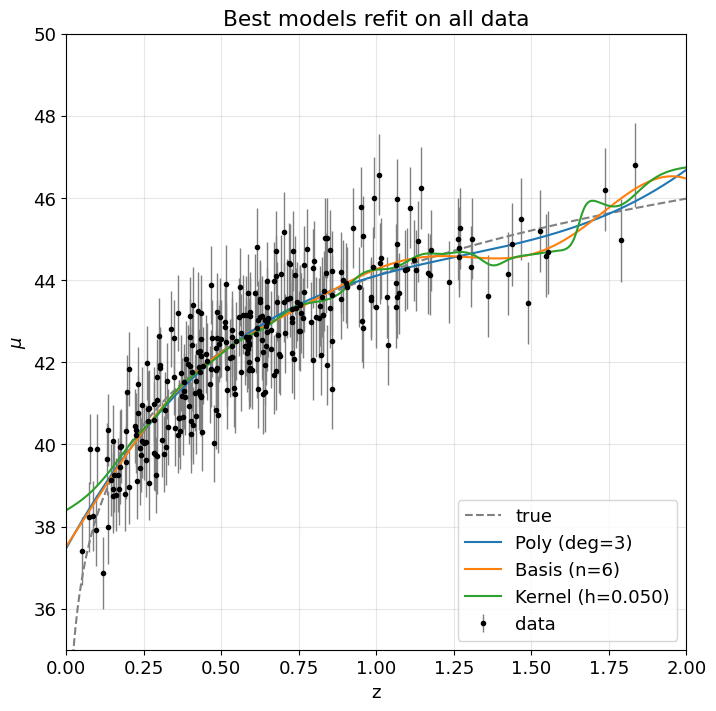

In [70]:

zgrid = np.linspace(0.0, 2.0, 400)

# Polynomial
deg_best = int(best_poly[0])
regP = PolynomialRegression(degree=deg_best).fit(z_sample[:, None], mu_sample, dmu)
muP = regP.predict(zgrid[:, None])

# Basis
n_best = int(best_basis[0])
basis_mu = np.linspace(0, 2, n_best)[:, None]
basis_sigma = 1.0 * (basis_mu[1] - basis_mu[0]) if n_best>1 else 0.1
regB = BasisFunctionRegression('gaussian', mu=basis_mu, sigma=basis_sigma).fit(z_sample[:, None], mu_sample, dmu)
muB = regB.predict(zgrid[:, None])

# Kernel
h_best = float(best_kernel[0])
regK = NadarayaWatson('gaussian', h_best).fit(z_sample[:, None], mu_sample)
muK = regK.predict(zgrid[:, None])

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(z, mu_true, '--', c='gray', label='true')
plt.plot(zgrid, muP, label=f'Poly (deg={deg_best})')
plt.plot(zgrid, muB, label=f'Basis (n={n_best})')
plt.plot(zgrid, muK, label=f'Kernel (h={h_best:.3f})')
plt.xlabel("z"); plt.ylabel("$\mu$"); plt.title("Best models refit on all data")
plt.legend(loc='lower right'); plt.xlim(0,2); plt.ylim(35,50); plt.grid(True, alpha=0.3)
plt.show()


## 5) Learning curves 

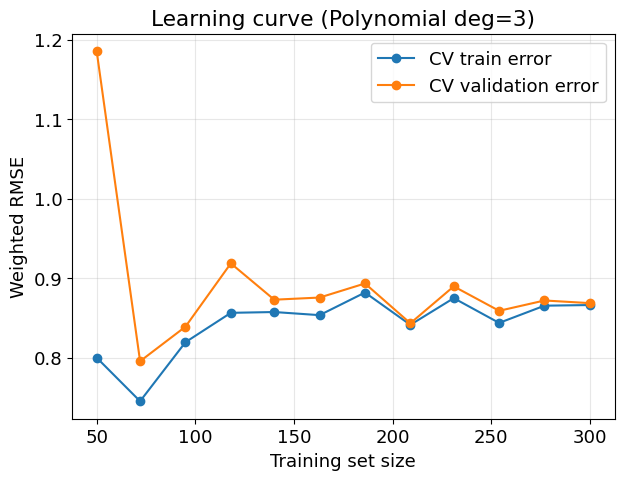

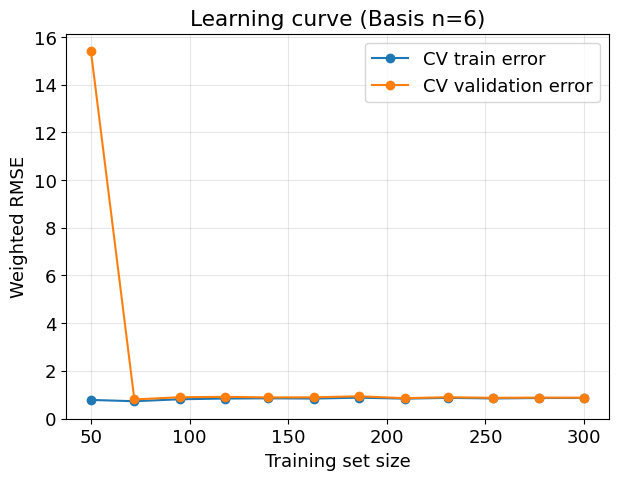

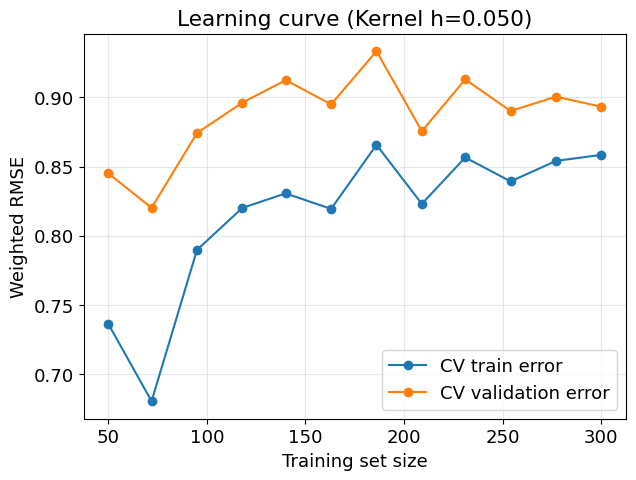

In [71]:

#Learning curves (errors as a function of sample size)
def learning_curve_cv(model_factory, sizes, X, y, s, k=8, seed=1234):
    sizes = np.asarray(sizes, dtype=int)
    mean_tr_err, mean_va_err = [], []
    rng = np.random.default_rng(seed)
    idx_all = np.arange(len(X))
    for n in sizes:
        rng.shuffle(idx_all)
        idx = idx_all[:n]
        Xs, ys, ss = X[idx], y[idx], s[idx]
        kf = KFold(n_splits=k, shuffle=True, random_state=11)
        tr_errs, va_errs = [], []
        for tr, te in kf.split(Xs):
            mdl = model_factory()
            if isinstance(mdl, NadarayaWatson):
                mdl.fit(Xs[tr][:, None], ys[tr])
                yhat_tr = mdl.predict(Xs[tr][:, None])
                yhat_te = mdl.predict(Xs[te][:, None])
            else:
                mdl.fit(Xs[tr][:, None], ys[tr], ss[tr])
                yhat_tr = mdl.predict(Xs[tr][:, None])
                yhat_te = mdl.predict(Xs[te][:, None])
            tr_errs.append(weighted_mse(ys[tr], yhat_tr, ss[tr]))
            va_errs.append(weighted_mse(ys[te], yhat_te, ss[te]))
        mean_tr_err.append(np.mean(tr_errs))
        mean_va_err.append(np.mean(va_errs))
    return sizes, np.array(mean_tr_err), np.array(mean_va_err)

# best hyperparameters 
poly_factory   = lambda: PolynomialRegression(degree=deg_best)
basis_factory  = lambda: BasisFunctionRegression('gaussian', mu=np.linspace(0, 2, n_best)[:, None],
                                                sigma=(np.linspace(0,2,n_best)[:, None][1]-np.linspace(0,2,n_best)[:, None][0]) if n_best>1 else 0.1)
kernel_factory = lambda: NadarayaWatson('gaussian', h_best)

sizes = np.unique(np.linspace(50, len(z_sample), 12, dtype=int))

sp, p_tr_lc, p_va_lc = learning_curve_cv(poly_factory, sizes, z_sample, mu_sample, dmu, k=8, seed=42)
sb, b_tr_lc, b_va_lc = learning_curve_cv(basis_factory, sizes, z_sample, mu_sample, dmu, k=8, seed=42)
sk, k_tr_lc, k_va_lc = learning_curve_cv(kernel_factory, sizes, z_sample, mu_sample, dmu, k=8, seed=42)

def plot_lc(sizes, tr, va, title):
    plt.figure(figsize=(7,5))
    plt.plot(sizes, tr, marker='o', label="CV train error")
    plt.plot(sizes, va, marker='o', label="CV validation error")
    plt.xlabel("Training set size"); plt.ylabel("Weighted RMSE"); plt.title(title)
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plot_lc(sp, p_tr_lc, p_va_lc, f"Learning curve (Polynomial deg={deg_best})")
plot_lc(sb, b_tr_lc, b_va_lc, f"Learning curve (Basis n={n_best})")
plot_lc(sk, k_tr_lc, k_va_lc, f"Learning curve (Kernel h={h_best:.3f})")
